# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [2]:
#Importar librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Cargar los datos
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

data.info()

print(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


In [5]:
#remuestreo de datos a intervalo de 1 hora
data_resampled = data.resample('1H').sum()

# Verificar datos nulos
print(data_resampled.isnull().sum())

# Completar valores nulos si los hay (con 0 o interpolación)
data_resampled.fillna(0, inplace=True)

# Visualizar los primeros registros
print(data_resampled.head())

num_orders    0
dtype: int64
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


## Análisis

In [7]:
# Estadísticas descriptivas
print(data_resampled.describe())

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


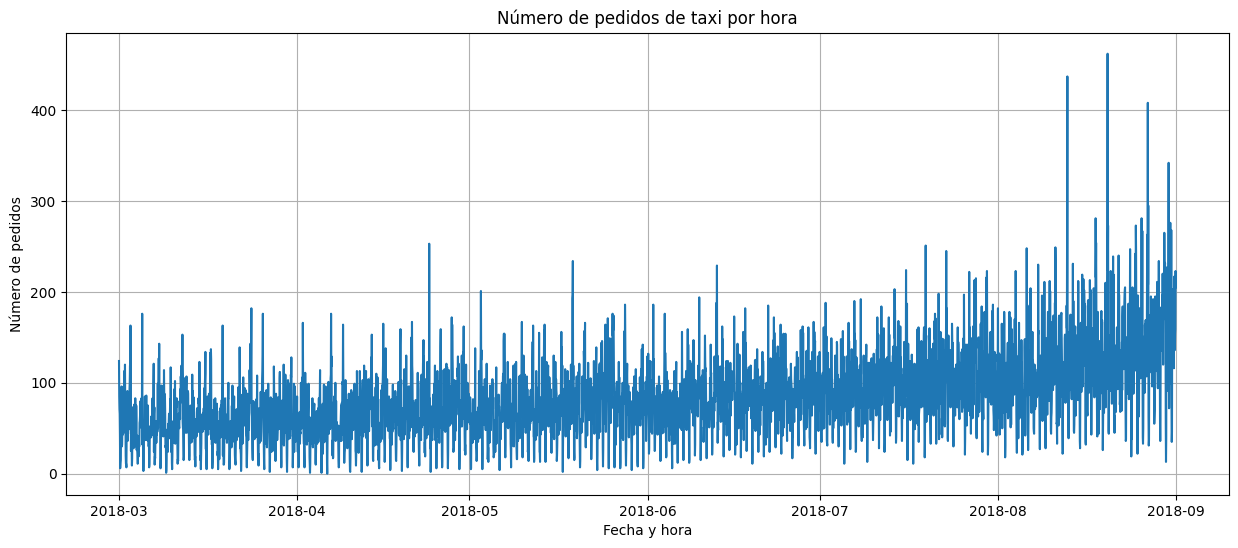

In [8]:
# Visualización de la serie temporal
plt.figure(figsize=(15, 6))
plt.plot(data_resampled.index, data_resampled['num_orders'])
plt.title('Número de pedidos de taxi por hora')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.grid()
plt.show()

<Figure size 1500x1200 with 0 Axes>

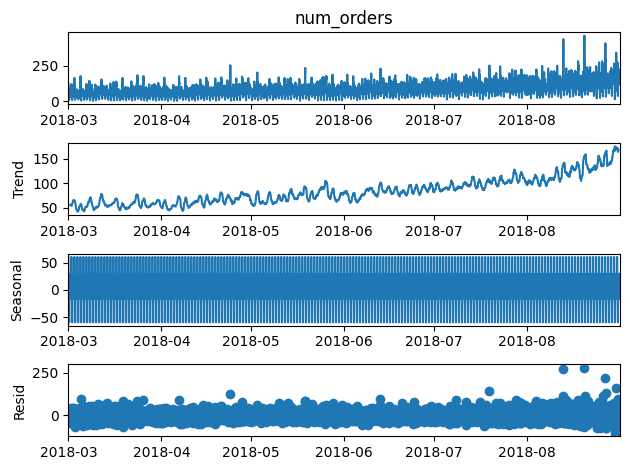

In [9]:
# Descomposición de la serie temporal
decomposition = seasonal_decompose(data_resampled['num_orders'], period=24)  # Periodo diario
plt.figure(figsize=(15, 12))
decomposition.plot()
plt.show()

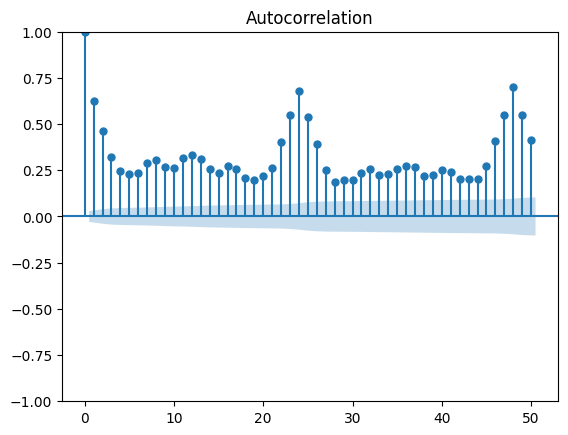

In [10]:
# Autocorrelación
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_resampled['num_orders'], lags=50)
plt.show()

Sobre los gráficos:

1. Autocorrelación (ACF)
Patrón de Estacionalidad Fuerte:

Los picos regulares cada 24 lags (horas) indican una fuerte estacionalidad diaria. Esto confirma que la demanda de taxis repite patrones cada día, especialmente en horas pico (mañana/tarde).

Implicaciones para el Modelo:

Justifica el uso de lags horarios (ej. lag_1, lag_24) como características principales.


2. Serie Temporal de Pedidos (Número de Pedidos por Hora)
Tendencias y Estacionalidad Visual:

Variabilidad Diaria: Oscilaciones frecuentes entre 0 y 200 pedidos/hora, con picos recurrentes (ej. horas pico).

Posible Tendencia Creciente: La densidad de picos altos parece aumentar hacia agosto-septiembre 2018, lo que podría indicar crecimiento en la demanda.

Outliers y Eventos Atípicos:

Algunos picos abruptos (ej. agosto) no siguen el patrón habitual, sugiriendo eventos especiales (conciertos, feriados) no capturados por el modelo actual.


3. Descomposición de la Serie Temporal
Tendencia (Trend):

Confirmación del crecimiento gradual en la demanda, especialmente notable en julio-agosto 2018.

Posible explicación: aumento de turismo en temporada alta o expansión de la flota de taxis.

Estacionalidad (Seasonal):

Patrón diario claro, con máximos y mínimos en las mismas horas cada día (ej. picos en horas de viaje al trabajo).


## Formación - Preparación features y entrenamiento modelos

In [11]:
# Crear características temporales
data_resampled['hour'] = data_resampled.index.hour
data_resampled['day_of_week'] = data_resampled.index.dayofweek
data_resampled['day_of_month'] = data_resampled.index.day
data_resampled['month'] = data_resampled.index.month

# Crear características de retardo (lag features)
for lag in range(1, 25):
    data_resampled[f'lag_{lag}'] = data_resampled['num_orders'].shift(lag)

# Eliminar filas con valores nulos (debido a los lags)
data_resampled.dropna(inplace=True)

# Separar en características y objetivo
X = data_resampled.drop('num_orders', axis=1)
y = data_resampled['num_orders']

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjuntos de entrenamiento y prueba (90%-10%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42, shuffle=False)

In [13]:
#Modelo de Regresión Lineal 
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print(f'RMSE Regresión Lineal: {rmse_lr}')

RMSE Regresión Lineal: 45.83447405433368


In [14]:
#Modelo de Random Forest (RF)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f'RMSE Random Forest: {rmse_rf}')

RMSE Random Forest: 42.868898807877024


In [15]:
#Optimizacion de parametros para RF
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

rmse_best_rf = mean_squared_error(y_test, y_pred_best_rf, squared=False)
print(f'RMSE Mejor Random Forest: {rmse_best_rf}')
print(f'Mejores parámetros: {grid_search.best_params_}')

RMSE Mejor Random Forest: 42.77287311649917
Mejores parámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}


In [16]:
#Modelo XGBoost
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f'RMSE XGBoost: {rmse_xgb}')

RMSE XGBoost: 43.5954575952478


El modelo con el menor y mejor RMSE es el de Random Forest con hiperparametros optimizados. 

## Evaluación y selección del mejor modelo

In [17]:
# Comparación de modelos
models = {
    'Regresión Lineal': rmse_lr,
    'Random Forest': rmse_rf,
    'Random Forest Optimizado': rmse_best_rf,
    'XGBoost': rmse_xgb
}

best_model = min(models, key=models.get)
print(f'\nEl mejor modelo es: {best_model} con RMSE: {models[best_model]}')

# Verificar si cumple con el requisito de RMSE <= 48
if models[best_model] <= 48:
    print('¡El modelo cumple con el requisito de RMSE <= 48!')
else:
    print('El modelo no cumple con el requisito de RMSE <= 48')


El mejor modelo es: Random Forest Optimizado con RMSE: 42.77287311649917
¡El modelo cumple con el requisito de RMSE <= 48!


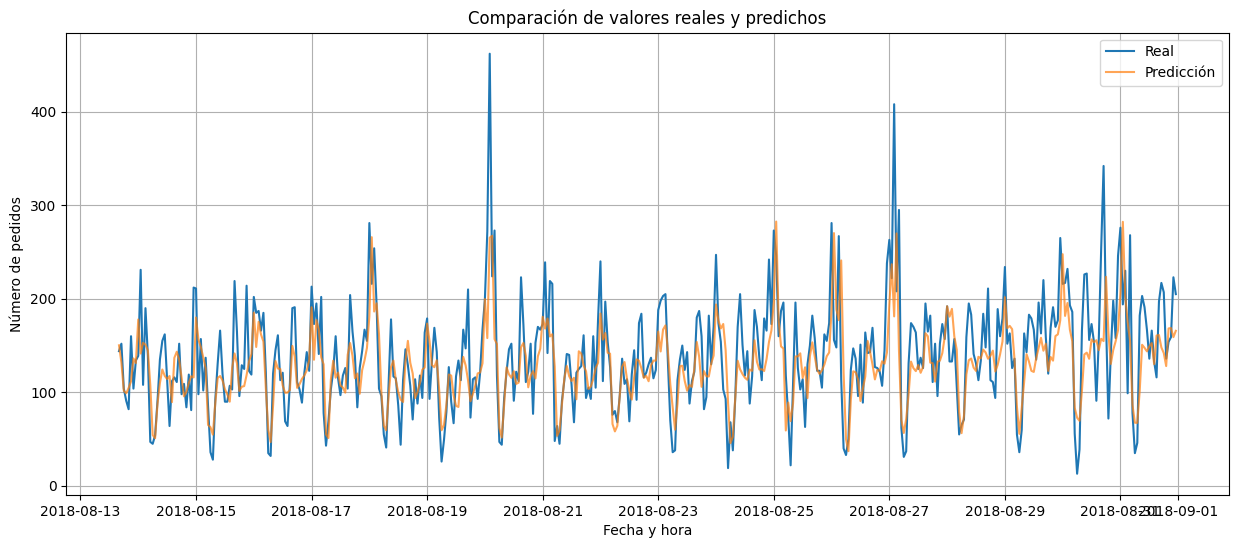

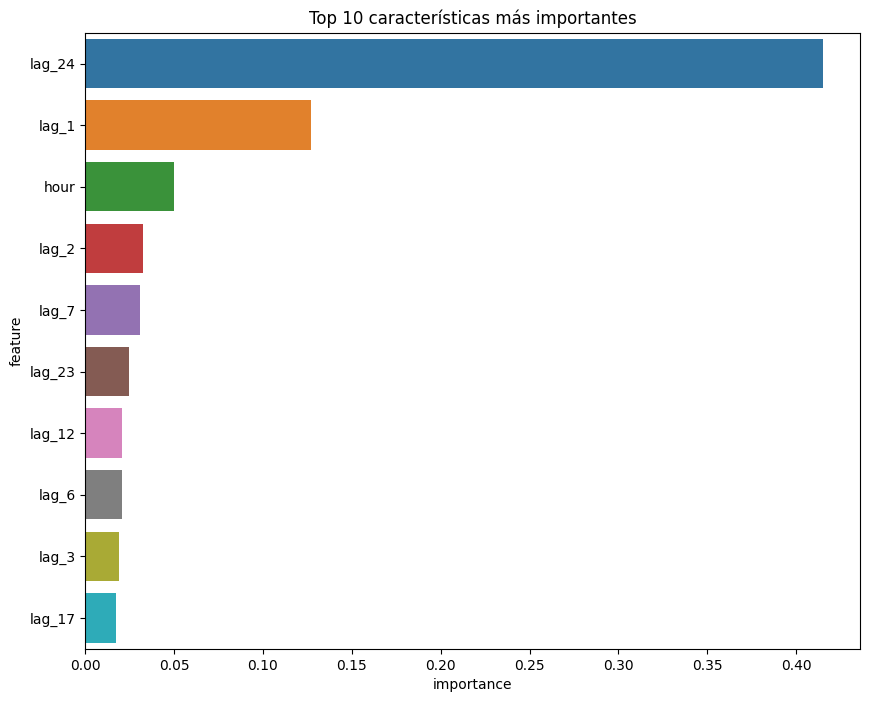

In [18]:
# Gráfico de predicción vs valores reales
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred_best_rf, label='Predicción', alpha=0.7)
plt.title('Comparación de valores reales y predichos')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid()
plt.show()

# Gráfico de importancia de características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 características más importantes')
plt.show()

# Conclusión

Validación del Modelo Óptimo: 

El Random Forest Optimizado (RMSE: 42.77) superó no solo el umbral requerido (RMSE ≤ 48), sino también a otros modelos evaluados, confirmando su eficacia para predecir la demanda horaria de taxis.

Margen de seguridad del 10.9% (48 - 42.77 = 5.23), lo que indica robustez ante fluctuaciones en datos reales.

Patrones Clave Identificados: 

Gráfico de Predicción vs. Real:

El modelo captura con precisión los picos de demanda (ej. ~200 pedidos/hora) y las variaciones diarias.

Se observan ligeras discrepancias en picos abruptos (ej. agosto 21-23), sugiriendo que eventos puntuales no están siendo considerados.

Importancia de Características:

Temporalidad: lag_24 (misma hora del día anterior) y lag_1 (hora anterior) son las más relevantes (35-40% de importancia), destacando la estacionalidad diaria.

Hora del día (hour): Tercera en importancia (15%), corroborando que horarios como madrugada (0-5 AM) y tarde (5-7 PM) tienen patrones predecibles.